In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_2par as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch

def reset_matplotlib():
    # Reset all matplotlib settings to defaults
    mpl.rcdefaults()

    # Create a default handler map and update it globally
    default_handler_map = {
        mpl.lines.Line2D: HandlerLine2D(numpoints=1),
        mpl.patches.Patch: HandlerPatch()
    }

    # Update the default handler map globally
    mpl.legend.Legend.update_default_handler_map(default_handler_map)

# Call this function at the start of your script to globally reset settings
reset_matplotlib()

import getpass
uname = getpass.getuser()
figtype = None #"notebook"

plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.rcParams.update({'font.serif': 'Times', 'font.family' : 'serif'})


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from scipy.sparse.linalg import eigsh
r = np.loadtxt("data/cache_delta_psi_3rd.txt")
f_n_orig = np.loadtxt("data/cache_freq_3rd.txt")
fend = f_n_orig[-1]


μ = np.mean(r, axis=0)
σ = np.var(r, axis=0)**(1/2)
R = r - μ
temp = np.einsum('ij,ik->jk', R, R)  # this computes the outer product of ΔΨ(f)*ΔΨ(f') as 2d array and sums it.
cov = temp/len(r[:,0]) # the two point function is the divided by the number of averages.

nλ = 1
λ, v  = eigsh(cov, nλ)
v = np.sign(v[-1,:])* v
# * 56.41895835477563
def get_dpsi_nvnl(freqs, p):
    Mc = p["M_c"]
    eta = p["eta"]
    dPsi = 1/1e-3 / 56.41895835477563 * np.sqrt(λ) * v[:,0]

    M = pycbc.conversions.mtotal_from_mchirp_eta(Mc,eta)*Ms
    
    intp = interp.interp1d(f_n_orig, dPsi, kind='linear', fill_value = (0, dPsi[-1]), bounds_error=False)
    dPsi = intp(freqs*M) / 25.336792812542917
    return dPsi

In [3]:
# Ground stuff
n_freq = 2000
fmin = 10.
fmax = 1000.
freqs = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))


full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))

psd = lib.read_mag(freqs, "curves/o3_l1.txt")**2
# psd = lib.read_mag(freqs, "../curves/ce1.txt")**2

data_150914 = np.array(data[0])
data_150914[0] = 30
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390

idx = '150914'
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))

In [4]:

get_dh_H1  = jax.jit(lib.get_dh_H1)
get_dh_L1  = jax.jit(lib.get_dh_L1)
get_dh_V1  = jax.jit(lib.get_dh_V1)

get_h_H1   = jax.jit(lib.get_h_H1)
get_h_L1   = jax.jit(lib.get_h_L1)
get_h_V1   = jax.jit(lib.get_h_V1)

a = get_dh_H1(red_param, freqs)
a = get_dh_L1(red_param, freqs)
a = get_dh_V1(red_param, freqs)
a = get_h_H1(red_param, freqs)
a = get_h_L1(red_param, freqs)
a = get_h_V1(red_param, freqs)
# dh_L1  = get_dh_L1(red_param, freqs)
# dh_V1  = get_dh_V1(red_param, freqs)

In [5]:
# kk = [-2,3]

# def calc_FI_main(idx, kk):
#     names_ppe = names + [f"phi_{k}" for k in kk]


#     idx_par =  {names_ppe[i] : i for i in range(len(names_ppe))} # indexes for fisher matrix
#     log_flag =  {names_ppe[i] : 0 for i in range(len(names_ppe))} # I want the derivate to be wrt log M_c and log Dl
#     log_flag["M_c"] = 1; log_flag["d_L"] = 1
#     if idx=='150914':
#         dat = jnp.array(data_150914)
    
#     red_param = dict(zip(names, jnp.array(dat).T))

#     dh_H1  = get_dh_H1(red_param, freqs)
#     dh_L1  = get_dh_L1(red_param, freqs)
#     dh_V1  = get_dh_V1(red_param, freqs)
    
#     h_H1   = get_h_H1(red_param, freqs)
#     h_L1   = get_h_L1(red_param, freqs)
#     h_V1   = get_h_V1(red_param, freqs)

#     for k in kk:
#         dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
#         dh_H1[f"phi_{k}"] = 1j*dpsi_ppe*h_H1
#         dh_L1[f"phi_{k}"] = 1j*dpsi_ppe*h_L1
#         dh_V1[f"phi_{k}"] = 1j*dpsi_ppe*h_V1
    
#     fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_par, psd, log_flag)
#     fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_par, psd, log_flag)
#     fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_par, psd, log_flag)
#     fi = fi_H1 + fi_L1 + fi_V1
#     return fi, names_ppe

# fi, names_ppe = calc_FI_main('150914',kk)
# jnp.diag(sla.inv(fi))

In [12]:
def compute_bias(dh, dh_nvnl, psd, freqs, idx_par):
    res = { key : jnp.real(lib.innprod(dh[key], dh_nvnl, psd, freqs)) for key in dh.keys()}
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
    return jnp.real(jnp.array(bias))

def get_projections(sub_par, red_param, deltapsi):
    idx_subpar = {sub_par[i] : i for i in range(len(sub_par))}
    log_flag_subpar = log_flag.copy()
    

    h_H1   = get_h_H1(red_param, freqs)
    h_L1   = get_h_L1(red_param, freqs)
    h_V1   = get_h_V1(red_param, freqs)

    dhperp = np.zeros((len(freqs)), dtype=np.complex128)
    dhpara = np.zeros((len(freqs)), dtype=np.complex128)
    
    dpsiperp = np.zeros((len(freqs)))
    dpsipara = np.zeros((len(freqs)))
    # fi_H1, fi_L1, fi_V1
    # fi_H1, fi_L1, fi_V1 = lib.get_FI_ppe(freqs, red_param, idx_subpar, psd, log_flag, k)
    


    dh_H1  = get_dh_H1(red_param, freqs)
    dh_L1  = get_dh_L1(red_param, freqs)
    dh_V1  = get_dh_V1(red_param, freqs)

    phi_keys = [key for key in sub_par if key.startswith('phi_')]
    print(phi_keys)
    for phik in phi_keys:
        k = int(phik.split('_')[1])
        dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
        dh_H1[phik] = 1j*dpsi_ppe*h_H1
        dh_L1[phik] = 1j*dpsi_ppe*h_L1
        dh_V1[phik] = 1j*dpsi_ppe*h_V1
        log_flag_subpar[phik] = 0
        red_param[phik] = 0
    # print(sub_par)
    # print(log_flag_subpar)
    # print(dh_H1)
    # print(red_param)
    # print(idx_subpar)
    
    fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_subpar, psd, log_flag_subpar)
    fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_subpar, psd, log_flag_subpar)
    fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_subpar, psd, log_flag_subpar)
    fi = fi_H1 + fi_L1 + fi_V1

    for i in log_flag_subpar.keys():
        if log_flag_subpar[i]:
            dh_H1[i] = dh_H1[i] * red_param[i]
            dh_L1[i] = dh_L1[i] * red_param[i]
            dh_V1[i] = dh_V1[i] * red_param[i]



    V = compute_bias(dh_H1,1j*deltapsi*h_H1, psd, freqs, idx_subpar) + compute_bias(dh_L1,1j*deltapsi*h_L1, psd, freqs, idx_subpar) + compute_bias(dh_V1,1j*deltapsi*h_V1, psd, freqs, idx_subpar)
    V = np.array(V)
    
    
    dh = np.array([dh_H1[s] for s in sub_par])
    lam = V @ sla.inv(fi)
    
    

    dhtot = 1j*deltapsi*h_H1
    dhperp =  (dhtot - lam @ dh)
    dhpara = lam @ dh
    
    dpsi = deltapsi
    dpsiperp = dhperp/ (1j * h_H1)
    dpsipara = dhpara/ (1j * h_H1)

    return dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam




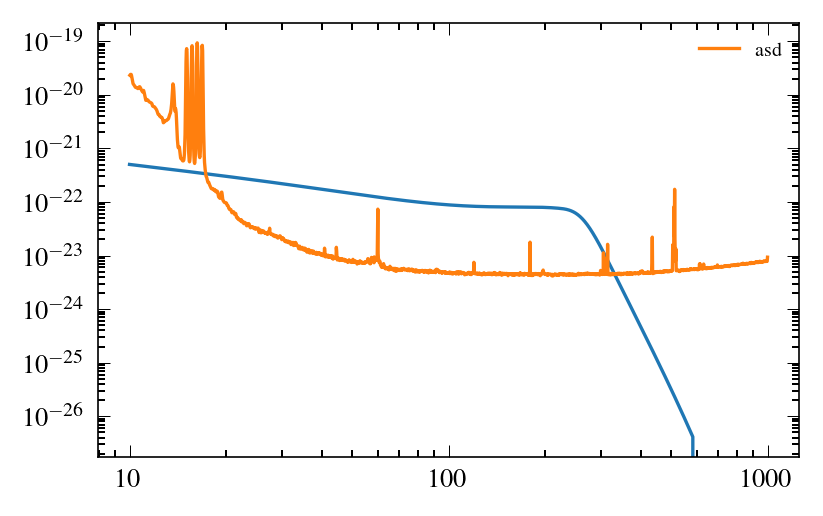

In [13]:
plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(get_h_H1(red_param, freqs)))

plt.plot(freqs, psd**(1/2), label='asd')
plt.legend(loc = 0,handler_map=None)
plt.show()

In [14]:
log_flag =  {names[i] : 0 for i in range(len(names))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1

idx = '150914'
red_param = dict(zip(names, jnp.array(dat).T))

dpsi_nvnl = get_dpsi_nvnl(freqs, red_param)
K = [-2,-1,0,1,2,3,4,6,7]

k = -2
dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
sub_par = names + ["phi_-2"]
idx_subpar = {sub_par[i] : i for i in range(len(sub_par))}
dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, bias = get_projections(sub_par, red_param, dpsi_nvnl)
# plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$")

['phi_-2']
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>
JitTracer<~int64[]> JitTracer<~int64[]>


['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 'phi_0']
['phi_0']
['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 'phi_1']


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_15051/4205184656.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$")
/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_15051/4205184656.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$")


TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int64. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

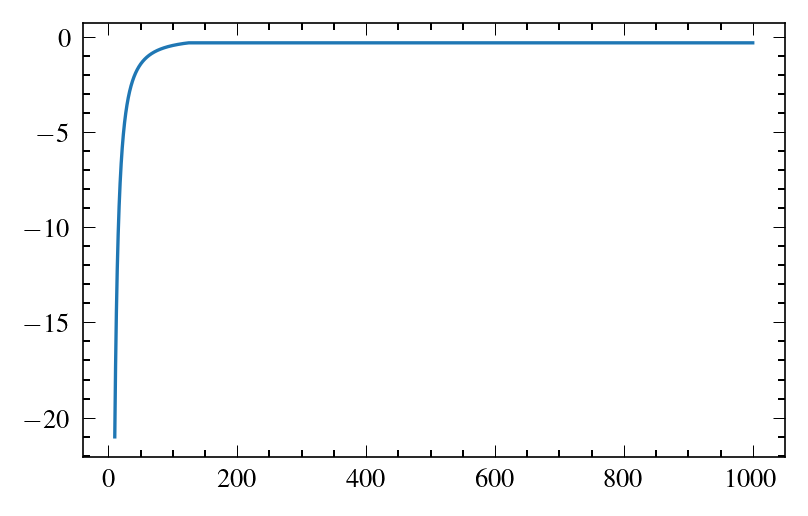

In [17]:
log_flag =  {names[i] : 0 for i in range(len(names))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1

idx = '150914'
red_param = dict(zip(names, jnp.array(dat).T))

dpsi_nvnl = get_dpsi_nvnl(freqs, red_param)
K = [0,1,2,3,4,6,7]
for k in K:
    
    dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
    sub_par = names + [f"phi_{k}"]
    print(sub_par)
    idx_subpar = {sub_par[i] : i for i in range(len(sub_par))}
    dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, bias = get_projections(sub_par, red_param, dpsi_nvnl)
    plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$")


# dpsi_nvnl = get_dpsi_nvnl(freqs, red_param)

plt.plot(freqs, dpsi_nvnl, "k", label = r"$\Delta \psi_\mathrm{ Opt }$")
plt.xlim(right = 150,left = 20)
plt.ylim(-4,4)
plt.xlabel(r"$f$ [Hz]") 
plt.ylabel(r"$\Delta \Psi$") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncols=1,handler_map=None,frameon=True)

# plt.axvspan(freqs[0], 30, alpha=0.1, color='red')
# plt.axvspan(300, freqs[-1], alpha=0.1, color='red')

# plt.savefig(datestr+"-deltapsi-nominal-comparison.pdf") 
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_14174/1575283142.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$",color =color)
/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_14174/1575283142.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$",color =color)


KeyError: 'phi_-2'

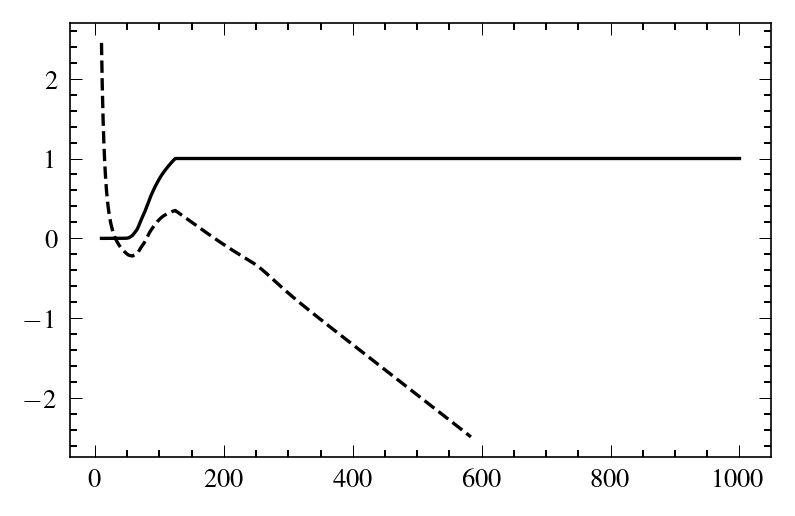

In [16]:
dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam = get_projections(names, red_param, dpsi_nvnl)
plt.plot(freqs, dpsi_nvnl, "k", label=r'$\Delta\Psi$')
plt.plot(freqs, dpsiperp, "k--", label=r'$\Delta\Psi_{\perp \mathrm{gr}}$')
Kless = [-2,4,7]
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for k in Kless:
    color = color_cycle[K.index(k)]
    sub_par = names + [f"phi_{ k }"]
    idx_subpar = {sub_par[i] : i for i in range(len(sub_par))}
    dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
    
    dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, bias = get_projections(sub_par, red_param, dpsi_nvnl)
    _, _, _, _, dpsi_ppe_perp, _, _ = get_projections(names, red_param, dpsi_ppe)

    plt.plot(freqs,bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe, label = f"$\Delta \psi_{ {k} }$",color =color)
    plt.plot(freqs, bias[idx_subpar[f"phi_{k}"]]*dpsi_ppe_perp, color = color, ls = "--")
plt.ylim(bottom = -4,top = 4)
plt.xlim(right = 150,left = 20)
plt.legend(loc = 0,handler_map=None)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),ncols=3,handler_map=None,frameon=True)
plt.ylabel(r"$\Delta\Psi  $ ")
plt.xlabel(r"$f$ [Hz]") 
# plt.savefig(datestr+"-deltapsi-projected-comparison.pdf") 
plt.show()

dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam = get_projections(names, red_param, dpsi_nvnl)
k=7
sub_par = names + [f"phi_{ k }"]
dhtot, dhperp_gr1ppe, dhpara_gr1ppe, _, _, _, _ = get_projections(sub_par, red_param, dpsi_nvnl)
f = np.array(freqs)
plt.loglog(f, 2*np.sqrt(freqs)*np.abs(get_h_H1(red_param, freqs)), label=r'$h$')
plt.loglog(f, 2*np.sqrt(freqs)* np.abs(dhtot), label=r'$\Delta h$')
plt.plot(f, 2*np.sqrt(freqs)* np.abs(dhperp), label=r'$\Delta h_{\perp \mathrm{gr}}$')
# plt.plot(f, 2*np.sqrt(freqs)* np.abs(dhpara), label=r'$\Delta h_{\parallel \mathrm{gr}}$')
# plt.plot(f, 2*np.sqrt(freqs)* np.abs(dhperp_gr1ppe), label=f'$\Delta h_{{\perp \mathrm{{gr+\delta\phi_{7} }}}}$')
# plt.plot(f, 2*np.sqrt(freqs)* np.abs(dhpara_gr1ppe), label=f'$\Delta h_{{\parallel \mathrm{{gr+\delta\phi_{k} }}}}$')
plt.plot(f, psd**(1/2), label='O3 ASD(f)')
# plt.legend(loc = 0,handler_map=None)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),ncols=4,handler_map=None,frameon=True)
plt.ylim(bottom=1e-24, top = 1e-21)
plt.ylabel(r"$2\sqrt{f} \vert \Delta h \vert   $ ")
plt.xlabel(r"$f$ [Hz]") 
plt.savefig(datestr+"-amplitude-projected-comparison.pdf") 
plt.show()

In [12]:
from jimgw.detector import H1, L1, V1
from jimgw.waveform import RippleIMRPhenomPv2, RippleIMRPhenomD
import jax
import jax.numpy as jnp
from jax import grad, vmap

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
# Assuming 'waveform' is defined elsewhere, or you can import it
waveform = RippleIMRPhenomPv2(f_ref=20)
# waveform = RippleIMRPhenomD(f_ref=20)

def get_h_slow(x, f, detector):
    # Set default parameters
    zero_vector = jnp.array(0.)
    for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z', 'gmst', 'epoch']:
        x[key] = zero_vector
    epsilon = jnp.array(1e-6)
    for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
        x[key] = epsilon

    ff = jnp.array([f])
    h_sky = waveform(ff, x)
    align_time = jnp.exp(-1j * 2 * jnp.pi * ff * (x['epoch'] + x['t_c']))
    signal = detector.fd_response(ff, h_sky, x) * align_time
    return signal[0]

def get_dh(x, f, detector):
    # Define a function to compute the real and imaginary parts
    def h_real(x, f):
        return get_h_slow(x, f, detector).real

    def h_imag(x, f):
        return get_h_slow(x, f, detector).imag

    # Compute gradients
    ur = vmap(grad(h_real), in_axes=(None, 0))(x, f)
    ui = vmap(grad(h_imag), in_axes=(None, 0))(x, f)
    dh = {key: ur.get(key, 0) + 1j * ui.get(key, 0) for key in x}
    return dh

# Create generic functions for each detector
def get_h(x, f, detector):
    return vmap(lambda f_single: get_h_slow(x, f_single, detector))(f)

# Example usage:
# For H1 detector
# h_H1 = get_h(x, f, H1)
# dh_H1 = get_dh(x, f, H1)

# # For L1 detector
# h_L1 = get_h(x, f, L1)
# dh_L1 = get_dh(x, f, L1)

# # For V1 detector
# h_V1 = get_h(x, f, V1)
# dh_V1 = get_dh(x, f, V1)
print(dat)
red_param = dict(zip(names, jnp.array(dat).T))
h_H1 = get_h(red_param, freqs,H1)
dh_H1 = get_dh(red_param, freqs, H1)
print(dh_H1)

[ 3.00000000e+01  2.46559096e-01  3.90000000e+02  1.69254929e+00
  9.39189162e-01  2.35481238e+00 -1.20559143e+00  0.00000000e+00
  0.00000000e+00  3.11972828e-01 -2.94431267e+00  2.22488005e+01
  5.91396128e+00  5.53731831e+00  7.77006698e+00  1.12254520e+01]
{'M_c': Array([6.16157358e-22-4.67635760e-22j,
       7.68038492e-22+1.73560062e-23j,
       5.87635433e-22+4.86651927e-22j, ...,
       0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j], dtype=complex128), 'eta': Array([-2.09125844e-20+1.57593843e-20j,
       -2.60737971e-20-6.78697357e-22j,
       -1.99520175e-20-1.66394609e-20j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], dtype=complex128), 'd_L': Array([ 1.22805760e-25+1.62721322e-25j,
       -5.14485252e-27+2.03228663e-25j,
       -1.29730390e-25+1.55783586e-25j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.000

In [13]:
gethjit = jax.jit(get_h, static_argnums=2)
getdhjit = jax.jit(get_dh, static_argnums=2)
gethjit(red_param, freqs,H1)
# getdhjit(red_param, freqs,H1)red_param

Array([-4.78942466e-23-6.34613154e-23j,
        2.00649248e-24-7.92591784e-23j,
        5.05948519e-23-6.07555986e-23j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], dtype=complex128)

In [14]:
# red_param['s1_x'] = jnp.Array(0., dtype=float64),
type(red_param["M_c"])

jaxlib.xla_extension.ArrayImpl

In [15]:
red_param = dict(zip(names, jnp.array(dat).T))
print(red_param)
h_H1 = get_h(red_param, freqs,H1)
print(red_param)
# get_h(red_param, freqs,H1)

{'M_c': Array(30., dtype=float64), 'eta': Array(0.2465591, dtype=float64), 'd_L': Array(390., dtype=float64), 'ra': Array(1.69254929, dtype=float64), 'dec': Array(0.93918916, dtype=float64), 'iota': Array(2.35481238, dtype=float64), 'psi': Array(-1.20559143, dtype=float64), 't_c': Array(0., dtype=float64), 'phase_c': Array(0., dtype=float64)}
{'M_c': Array(30., dtype=float64), 'eta': Array(0.2465591, dtype=float64), 'd_L': Array(390., dtype=float64), 'ra': Array(1.69254929, dtype=float64), 'dec': Array(0.93918916, dtype=float64), 'iota': Array(2.35481238, dtype=float64), 'psi': Array(-1.20559143, dtype=float64), 't_c': Array(0., dtype=float64), 'phase_c': Array(0., dtype=float64), 's1_x': Array(1.e-06, dtype=float64, weak_type=True), 's1_y': Array(1.e-06, dtype=float64, weak_type=True), 's1_z': Array(1.e-06, dtype=float64, weak_type=True), 's2_x': Array(1.e-06, dtype=float64, weak_type=True), 's2_y': Array(1.e-06, dtype=float64, weak_type=True), 's2_z': Array(1.e-06, dtype=float64, wea

In [16]:


red_param['s1_z'] = jnp.array([0.01])
red_param

{'M_c': Array(30., dtype=float64),
 'eta': Array(0.2465591, dtype=float64),
 'd_L': Array(390., dtype=float64),
 'ra': Array(1.69254929, dtype=float64),
 'dec': Array(0.93918916, dtype=float64),
 'iota': Array(2.35481238, dtype=float64),
 'psi': Array(-1.20559143, dtype=float64),
 't_c': Array(0., dtype=float64),
 'phase_c': Array(0., dtype=float64),
 's1_x': Array(1.e-06, dtype=float64, weak_type=True),
 's1_y': Array(1.e-06, dtype=float64, weak_type=True),
 's1_z': Array([0.01], dtype=float64),
 's2_x': Array(1.e-06, dtype=float64, weak_type=True),
 's2_y': Array(1.e-06, dtype=float64, weak_type=True),
 's2_z': Array(1.e-06, dtype=float64, weak_type=True),
 'gmst': Array(0., dtype=float64, weak_type=True),
 'epoch': Array(0., dtype=float64, weak_type=True)}

In [17]:
getdhjit(red_param, freqs,H1)["eta"] 

Array([-2.09085750e-20+1.57646225e-20j,
       -2.60739312e-20-6.72227240e-22j,
       -1.99560976e-20-1.66344136e-20j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], dtype=complex128)

In [18]:
get_dh_H1(red_param, freqs).keys()

dict_keys(['M_c', 'd_L', 'dec', 'epoch', 'eta', 'gmst', 'iota', 'phase_c', 'psi', 'ra', 's1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z', 't_c'])

In [19]:
get_dh_H1(red_param, freqs).keys()

dict_keys(['M_c', 'd_L', 'dec', 'epoch', 'eta', 'gmst', 'iota', 'phase_c', 'psi', 'ra', 's1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z', 't_c'])

In [20]:
def arctantest(x,y):
    return jnp.arctan2(y, x)

In [21]:
import ripple
print(ripple.__file__)

/home/darkknight/anaconda3/envs/qmstruct/lib/python3.10/site-packages/ripple/__init__.py
